###### **04-08** 분류 실습 - 캐글 산탄데르 고객 만족 예측

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('/content/train.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (59092, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0.0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0.0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0.0


In [18]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은{0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0.0    56813
1.0     2278
Name: count, dtype: int64
unsatisfied 비율은0.04


In [19]:
cust_df['ID']

0             1
1             3
2             4
3             8
4            10
          ...  
59087    117937
59088    117938
59089    117939
59090    117940
59091    117944
Name: ID, Length: 59092, dtype: int64

In [20]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 Shape:{0}'.format(X_features.shape))

피처 데이터 Shape:(59092, 369)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습 세트 Shape:{0},테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))
print('학습 세트 레이블값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(47273, 369),테스트 세트 Shape:(11819, 369)
학습 세트 레이블값 분포 비율
TARGET
0.0    0.961542
1.0    0.038458
Name: count, dtype: float64

 테스트 세트 레이블값 분포 비율
TARGET
0.0    0.96108
1.0    0.03892
Name: count, dtype: float64


###### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [25]:
import numpy as np

# 결측치를 NaN으로 처리하는 예시 코드
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 해당 열의 중간값으로 대체하는 예시 코드
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

# 레이블에 결측치가 있는 경우 해당 샘플을 제거하는 예시 코드
not_nan_index = ~np.isnan(y_train)
X_train = X_train[not_nan_index]
y_train = y_train[not_nan_index]

not_nan_index = ~np.isnan(y_test)
X_test = X_test[not_nan_index]
y_test = y_test[not_nan_index]


In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, random_state=156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83451	validation_1-auc:0.81392
[1]	validation_0-auc:0.84620	validation_1-auc:0.82689
[2]	validation_0-auc:0.85233	validation_1-auc:0.82873
[3]	validation_0-auc:0.85691	validation_1-auc:0.83167
[4]	validation_0-auc:0.86109	validation_1-auc:0.83369
[5]	validation_0-auc:0.86492	validation_1-auc:0.83423
[6]	validation_0-auc:0.86734	validation_1-auc:0.83562
[7]	validation_0-auc:0.87084	validation_1-auc:0.83595
[8]	validation_0-auc:0.87497	validation_1-auc:0.83578
[9]	validation_0-auc:0.87787	validation_1-auc:0.83489
[10]	validation_0-auc:0.88066	validation_1-auc:0.83469
[11]	validation_0-auc:0.88322	validation_1-auc:0.83500
[12]	validation_0-auc:0.88525	validation_1-auc:0.83602
[13]	validation_0-auc:0.88757	validation_1-auc:0.83575
[14]	validation_0-auc:0.88937	validation_1-auc:0.83538
[15]	validation_0-auc:0.89138	validation_1-auc:0.83499
[16]	validation_0-auc:0.89181	validation_1-auc:0.83516
[17]	validation_0-auc:0.89275	validation_1-auc:0.83541
[18]	validation_0-au

In [27]:
# ROC-AUC 수치의 향상 현황 확인
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree': [0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=2)
gridcv.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터: ' , gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80835	validation_1-auc:0.79805
[1]	validation_0-auc:0.80977	validation_1-auc:0.79658
[2]	validation_0-auc:0.79567	validation_1-auc:0.78139
[3]	validation_0-auc:0.80014	validation_1-auc:0.78167
[4]	validation_0-auc:0.82850	validation_1-auc:0.80769
[5]	validation_0-auc:0.84029	validation_1-auc:0.81600
[6]	validation_0-auc:0.84589	validation_1-auc:0.82096
[7]	validation_0-auc:0.84553	validation_1-auc:0.82021
[8]	validation_0-auc:0.85090	validation_1-auc:0.82355
[9]	validation_0-auc:0.85189	validation_1-auc:0.82679
[10]	validation_0-auc:0.85090	validation_1-auc:0.82558
[11]	validation_0-auc:0.85538	validation_1-auc:0.82834
[12]	validation_0-auc:0.85687	validation_1-auc:0.82842
[13]	validation_0-auc:0.85849	validation_1-auc:0.82972
[14]	validation_0-auc:0.85969	validation_1-auc:0.82835
[15]	validation_0-auc:0.86013	validation_1-auc:0.82832
[16]	validation_0-auc:0.86087	validation_1-auc:0.82939
[17]	validation_0-auc:0.86123	validation_1-auc:0.82938
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81476	validation_1-auc:0.80730
[1]	validation_0-auc:0.80957	validation_1-auc:0.80510
[2]	validation_0-auc:0.80604	validation_1-auc:0.80069
[3]	validation_0-auc:0.80299	validation_1-auc:0.79700
[4]	validation_0-auc:0.82977	validation_1-auc:0.81580
[5]	validation_0-auc:0.83857	validation_1-auc:0.82390
[6]	validation_0-auc:0.84528	validation_1-auc:0.82616
[7]	validation_0-auc:0.84514	validation_1-auc:0.82661
[8]	validation_0-auc:0.84913	validation_1-auc:0.83061
[9]	validation_0-auc:0.85025	validation_1-auc:0.82793
[10]	validation_0-auc:0.85042	validation_1-auc:0.82626
[11]	validation_0-auc:0.85450	validation_1-auc:0.82881
[12]	validation_0-auc:0.85697	validation_1-auc:0.82982
[13]	validation_0-auc:0.85745	validation_1-auc:0.82902
[14]	validation_0-auc:0.85873	validation_1-auc:0.82726
[15]	validation_0-auc:0.85857	validation_1-auc:0.82675
[16]	validation_0-auc:0.85952	validation_1-auc:0.82690
[17]	validation_0-auc:0.86093	validation_1-auc:0.82910


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80775	validation_1-auc:0.79112
[1]	validation_0-auc:0.81041	validation_1-auc:0.80144
[2]	validation_0-auc:0.79809	validation_1-auc:0.78760
[3]	validation_0-auc:0.80047	validation_1-auc:0.78676
[4]	validation_0-auc:0.82887	validation_1-auc:0.81472
[5]	validation_0-auc:0.83953	validation_1-auc:0.82082
[6]	validation_0-auc:0.84414	validation_1-auc:0.82324
[7]	validation_0-auc:0.84377	validation_1-auc:0.82133
[8]	validation_0-auc:0.84904	validation_1-auc:0.82651
[9]	validation_0-auc:0.84990	validation_1-auc:0.82483
[10]	validation_0-auc:0.84928	validation_1-auc:0.82510
[11]	validation_0-auc:0.85229	validation_1-auc:0.82877
[12]	validation_0-auc:0.85379	validation_1-auc:0.83008
[13]	validation_0-auc:0.85514	validation_1-auc:0.83063
[14]	validation_0-auc:0.85628	validation_1-auc:0.82971
[15]	validation_0-auc:0.85656	validation_1-auc:0.82916
[16]	validation_0-auc:0.85739	validation_1-auc:0.82774
[17]	validation_0-auc:0.85800	validation_1-auc:0.82845
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81962	validation_1-auc:0.81668
[1]	validation_0-auc:0.81076	validation_1-auc:0.80674
[2]	validation_0-auc:0.81253	validation_1-auc:0.80243
[3]	validation_0-auc:0.80835	validation_1-auc:0.79987
[4]	validation_0-auc:0.83195	validation_1-auc:0.81943
[5]	validation_0-auc:0.83978	validation_1-auc:0.82543
[6]	validation_0-auc:0.84540	validation_1-auc:0.82611
[7]	validation_0-auc:0.84557	validation_1-auc:0.82738
[8]	validation_0-auc:0.84885	validation_1-auc:0.82895
[9]	validation_0-auc:0.84894	validation_1-auc:0.82826
[10]	validation_0-auc:0.85027	validation_1-auc:0.82700
[11]	validation_0-auc:0.85375	validation_1-auc:0.83090
[12]	validation_0-auc:0.85572	validation_1-auc:0.83121
[13]	validation_0-auc:0.85702	validation_1-auc:0.83064
[14]	validation_0-auc:0.85732	validation_1-auc:0.83019
[15]	validation_0-auc:0.85755	validation_1-auc:0.82974
[16]	validation_0-auc:0.85932	validation_1-auc:0.83041
[17]	validation_0-auc:0.86027	validation_1-auc:0.83069
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82522	validation_1-auc:0.79833
[1]	validation_0-auc:0.82756	validation_1-auc:0.80241
[2]	validation_0-auc:0.82150	validation_1-auc:0.79146
[3]	validation_0-auc:0.82041	validation_1-auc:0.78789
[4]	validation_0-auc:0.84212	validation_1-auc:0.80987
[5]	validation_0-auc:0.85065	validation_1-auc:0.81465
[6]	validation_0-auc:0.85704	validation_1-auc:0.81707
[7]	validation_0-auc:0.85829	validation_1-auc:0.81697
[8]	validation_0-auc:0.86369	validation_1-auc:0.82250
[9]	validation_0-auc:0.86480	validation_1-auc:0.82184
[10]	validation_0-auc:0.86478	validation_1-auc:0.82170
[11]	validation_0-auc:0.86872	validation_1-auc:0.82320
[12]	validation_0-auc:0.87127	validation_1-auc:0.82564
[13]	validation_0-auc:0.87266	validation_1-auc:0.82561
[14]	validation_0-auc:0.87320	validation_1-auc:0.82448
[15]	validation_0-auc:0.87460	validation_1-auc:0.82205
[16]	validation_0-auc:0.87617	validation_1-auc:0.82077
[17]	validation_0-auc:0.87725	validation_1-auc:0.82110
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82729	validation_1-auc:0.81691
[1]	validation_0-auc:0.82532	validation_1-auc:0.80898
[2]	validation_0-auc:0.82319	validation_1-auc:0.80518
[3]	validation_0-auc:0.82010	validation_1-auc:0.79712
[4]	validation_0-auc:0.84219	validation_1-auc:0.81771
[5]	validation_0-auc:0.85224	validation_1-auc:0.82248
[6]	validation_0-auc:0.85944	validation_1-auc:0.82487
[7]	validation_0-auc:0.86126	validation_1-auc:0.82388
[8]	validation_0-auc:0.86486	validation_1-auc:0.82671
[9]	validation_0-auc:0.86491	validation_1-auc:0.82347
[10]	validation_0-auc:0.86547	validation_1-auc:0.82108
[11]	validation_0-auc:0.86886	validation_1-auc:0.82044
[12]	validation_0-auc:0.87192	validation_1-auc:0.81971
[13]	validation_0-auc:0.87292	validation_1-auc:0.82129
[14]	validation_0-auc:0.87367	validation_1-auc:0.81978
[15]	validation_0-auc:0.87396	validation_1-auc:0.81916
[16]	validation_0-auc:0.87662	validation_1-auc:0.81930
[17]	validation_0-auc:0.87778	validation_1-auc:0.81893
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82230	validation_1-auc:0.79696
[1]	validation_0-auc:0.82481	validation_1-auc:0.79700
[2]	validation_0-auc:0.81985	validation_1-auc:0.79393
[3]	validation_0-auc:0.81434	validation_1-auc:0.79273
[4]	validation_0-auc:0.83848	validation_1-auc:0.81463
[5]	validation_0-auc:0.84613	validation_1-auc:0.81843
[6]	validation_0-auc:0.85271	validation_1-auc:0.82461
[7]	validation_0-auc:0.85379	validation_1-auc:0.82062
[8]	validation_0-auc:0.85981	validation_1-auc:0.82763
[9]	validation_0-auc:0.86039	validation_1-auc:0.82652
[10]	validation_0-auc:0.86049	validation_1-auc:0.82390
[11]	validation_0-auc:0.86399	validation_1-auc:0.82524
[12]	validation_0-auc:0.86720	validation_1-auc:0.82485
[13]	validation_0-auc:0.86823	validation_1-auc:0.82642
[14]	validation_0-auc:0.86874	validation_1-auc:0.82456
[15]	validation_0-auc:0.86929	validation_1-auc:0.82465
[16]	validation_0-auc:0.86969	validation_1-auc:0.82438
[17]	validation_0-auc:0.87016	validation_1-auc:0.82437


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82808	validation_1-auc:0.81465
[1]	validation_0-auc:0.82657	validation_1-auc:0.80837
[2]	validation_0-auc:0.82408	validation_1-auc:0.80837
[3]	validation_0-auc:0.82016	validation_1-auc:0.80142
[4]	validation_0-auc:0.84194	validation_1-auc:0.82015
[5]	validation_0-auc:0.85227	validation_1-auc:0.82530
[6]	validation_0-auc:0.85760	validation_1-auc:0.82463
[7]	validation_0-auc:0.85842	validation_1-auc:0.82341
[8]	validation_0-auc:0.86266	validation_1-auc:0.82543
[9]	validation_0-auc:0.86167	validation_1-auc:0.82422
[10]	validation_0-auc:0.86257	validation_1-auc:0.82164
[11]	validation_0-auc:0.86513	validation_1-auc:0.82249
[12]	validation_0-auc:0.86697	validation_1-auc:0.82347
[13]	validation_0-auc:0.86866	validation_1-auc:0.82558
[14]	validation_0-auc:0.86885	validation_1-auc:0.82488
[15]	validation_0-auc:0.86862	validation_1-auc:0.82405
[16]	validation_0-auc:0.87009	validation_1-auc:0.82389
[17]	validation_0-auc:0.87058	validation_1-auc:0.82386
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80769	validation_1-auc:0.79135
[1]	validation_0-auc:0.82482	validation_1-auc:0.80762
[2]	validation_0-auc:0.82125	validation_1-auc:0.80801
[3]	validation_0-auc:0.83757	validation_1-auc:0.82011
[4]	validation_0-auc:0.84196	validation_1-auc:0.82582
[5]	validation_0-auc:0.84452	validation_1-auc:0.82445
[6]	validation_0-auc:0.84637	validation_1-auc:0.82615
[7]	validation_0-auc:0.84772	validation_1-auc:0.82410
[8]	validation_0-auc:0.85004	validation_1-auc:0.82818
[9]	validation_0-auc:0.85146	validation_1-auc:0.82747
[10]	validation_0-auc:0.85308	validation_1-auc:0.82688
[11]	validation_0-auc:0.85442	validation_1-auc:0.82720
[12]	validation_0-auc:0.85556	validation_1-auc:0.82821
[13]	validation_0-auc:0.85672	validation_1-auc:0.82724
[14]	validation_0-auc:0.85765	validation_1-auc:0.82756
[15]	validation_0-auc:0.85804	validation_1-auc:0.82575
[16]	validation_0-auc:0.85896	validation_1-auc:0.82563
[17]	validation_0-auc:0.85964	validation_1-auc:0.82530
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81790	validation_1-auc:0.80717
[1]	validation_0-auc:0.83134	validation_1-auc:0.82234
[2]	validation_0-auc:0.83382	validation_1-auc:0.82233
[3]	validation_0-auc:0.83970	validation_1-auc:0.82684
[4]	validation_0-auc:0.84358	validation_1-auc:0.82644
[5]	validation_0-auc:0.84714	validation_1-auc:0.83081
[6]	validation_0-auc:0.84924	validation_1-auc:0.83019
[7]	validation_0-auc:0.85100	validation_1-auc:0.83180
[8]	validation_0-auc:0.85195	validation_1-auc:0.83169
[9]	validation_0-auc:0.85419	validation_1-auc:0.83239
[10]	validation_0-auc:0.85608	validation_1-auc:0.83217
[11]	validation_0-auc:0.85717	validation_1-auc:0.83252
[12]	validation_0-auc:0.85884	validation_1-auc:0.83399
[13]	validation_0-auc:0.85926	validation_1-auc:0.83363
[14]	validation_0-auc:0.85971	validation_1-auc:0.83373
[15]	validation_0-auc:0.86026	validation_1-auc:0.83432
[16]	validation_0-auc:0.86115	validation_1-auc:0.83406
[17]	validation_0-auc:0.86115	validation_1-auc:0.83384
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80881	validation_1-auc:0.78798
[1]	validation_0-auc:0.82579	validation_1-auc:0.80674
[2]	validation_0-auc:0.82181	validation_1-auc:0.80749
[3]	validation_0-auc:0.83707	validation_1-auc:0.81723
[4]	validation_0-auc:0.84104	validation_1-auc:0.82454
[5]	validation_0-auc:0.84375	validation_1-auc:0.82631
[6]	validation_0-auc:0.84578	validation_1-auc:0.82761
[7]	validation_0-auc:0.84743	validation_1-auc:0.82672
[8]	validation_0-auc:0.84967	validation_1-auc:0.82849
[9]	validation_0-auc:0.85087	validation_1-auc:0.82851
[10]	validation_0-auc:0.85140	validation_1-auc:0.82671
[11]	validation_0-auc:0.85323	validation_1-auc:0.82709
[12]	validation_0-auc:0.85403	validation_1-auc:0.82717
[13]	validation_0-auc:0.85503	validation_1-auc:0.82723
[14]	validation_0-auc:0.85532	validation_1-auc:0.82645
[15]	validation_0-auc:0.85584	validation_1-auc:0.82647
[16]	validation_0-auc:0.85730	validation_1-auc:0.82603
[17]	validation_0-auc:0.85820	validation_1-auc:0.82573
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82220	validation_1-auc:0.81685
[1]	validation_0-auc:0.83020	validation_1-auc:0.82403
[2]	validation_0-auc:0.83397	validation_1-auc:0.82407
[3]	validation_0-auc:0.83896	validation_1-auc:0.82921
[4]	validation_0-auc:0.84294	validation_1-auc:0.83094
[5]	validation_0-auc:0.84643	validation_1-auc:0.83020
[6]	validation_0-auc:0.84920	validation_1-auc:0.83016
[7]	validation_0-auc:0.85032	validation_1-auc:0.83019
[8]	validation_0-auc:0.85238	validation_1-auc:0.83108
[9]	validation_0-auc:0.85425	validation_1-auc:0.83201
[10]	validation_0-auc:0.85566	validation_1-auc:0.83358
[11]	validation_0-auc:0.85731	validation_1-auc:0.83229
[12]	validation_0-auc:0.85786	validation_1-auc:0.83018
[13]	validation_0-auc:0.85910	validation_1-auc:0.83133
[14]	validation_0-auc:0.86037	validation_1-auc:0.83159
[15]	validation_0-auc:0.86044	validation_1-auc:0.83100
[16]	validation_0-auc:0.86041	validation_1-auc:0.83149
[17]	validation_0-auc:0.86054	validation_1-auc:0.83197
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82744	validation_1-auc:0.79986
[1]	validation_0-auc:0.83894	validation_1-auc:0.81440
[2]	validation_0-auc:0.84093	validation_1-auc:0.81442
[3]	validation_0-auc:0.84928	validation_1-auc:0.81908
[4]	validation_0-auc:0.85546	validation_1-auc:0.82664
[5]	validation_0-auc:0.85901	validation_1-auc:0.82511
[6]	validation_0-auc:0.86138	validation_1-auc:0.82735
[7]	validation_0-auc:0.86367	validation_1-auc:0.82281
[8]	validation_0-auc:0.86757	validation_1-auc:0.82381
[9]	validation_0-auc:0.86963	validation_1-auc:0.82395
[10]	validation_0-auc:0.87063	validation_1-auc:0.82226
[11]	validation_0-auc:0.87166	validation_1-auc:0.82172
[12]	validation_0-auc:0.87410	validation_1-auc:0.82170
[13]	validation_0-auc:0.87467	validation_1-auc:0.82025
[14]	validation_0-auc:0.87553	validation_1-auc:0.81933
[15]	validation_0-auc:0.87635	validation_1-auc:0.81961
[16]	validation_0-auc:0.87641	validation_1-auc:0.81932


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83147	validation_1-auc:0.81855
[1]	validation_0-auc:0.84134	validation_1-auc:0.82485
[2]	validation_0-auc:0.84220	validation_1-auc:0.82225
[3]	validation_0-auc:0.84929	validation_1-auc:0.82492
[4]	validation_0-auc:0.85349	validation_1-auc:0.82624
[5]	validation_0-auc:0.85941	validation_1-auc:0.82676
[6]	validation_0-auc:0.86329	validation_1-auc:0.82740
[7]	validation_0-auc:0.86402	validation_1-auc:0.82582
[8]	validation_0-auc:0.86657	validation_1-auc:0.82737
[9]	validation_0-auc:0.87017	validation_1-auc:0.82772
[10]	validation_0-auc:0.87162	validation_1-auc:0.82677
[11]	validation_0-auc:0.87325	validation_1-auc:0.82667
[12]	validation_0-auc:0.87432	validation_1-auc:0.82328
[13]	validation_0-auc:0.87506	validation_1-auc:0.82415
[14]	validation_0-auc:0.87651	validation_1-auc:0.82359
[15]	validation_0-auc:0.87672	validation_1-auc:0.82357
[16]	validation_0-auc:0.87730	validation_1-auc:0.82390
[17]	validation_0-auc:0.87789	validation_1-auc:0.82523
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82700	validation_1-auc:0.80102
[1]	validation_0-auc:0.83769	validation_1-auc:0.81509
[2]	validation_0-auc:0.83802	validation_1-auc:0.81616
[3]	validation_0-auc:0.84622	validation_1-auc:0.81835
[4]	validation_0-auc:0.85020	validation_1-auc:0.82355
[5]	validation_0-auc:0.85444	validation_1-auc:0.82511
[6]	validation_0-auc:0.85697	validation_1-auc:0.82585
[7]	validation_0-auc:0.86010	validation_1-auc:0.82486
[8]	validation_0-auc:0.86286	validation_1-auc:0.82696
[9]	validation_0-auc:0.86342	validation_1-auc:0.82633
[10]	validation_0-auc:0.86501	validation_1-auc:0.82561
[11]	validation_0-auc:0.86626	validation_1-auc:0.82620
[12]	validation_0-auc:0.86678	validation_1-auc:0.82619
[13]	validation_0-auc:0.86746	validation_1-auc:0.82538
[14]	validation_0-auc:0.86919	validation_1-auc:0.82490
[15]	validation_0-auc:0.86930	validation_1-auc:0.82313
[16]	validation_0-auc:0.86980	validation_1-auc:0.82280
[17]	validation_0-auc:0.87059	validation_1-auc:0.82226
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83144	validation_1-auc:0.81807
[1]	validation_0-auc:0.83996	validation_1-auc:0.82428
[2]	validation_0-auc:0.83892	validation_1-auc:0.82369
[3]	validation_0-auc:0.84631	validation_1-auc:0.82831
[4]	validation_0-auc:0.85046	validation_1-auc:0.82914
[5]	validation_0-auc:0.85560	validation_1-auc:0.82969
[6]	validation_0-auc:0.85900	validation_1-auc:0.82839
[7]	validation_0-auc:0.86002	validation_1-auc:0.82645
[8]	validation_0-auc:0.86232	validation_1-auc:0.82656
[9]	validation_0-auc:0.86441	validation_1-auc:0.82789
[10]	validation_0-auc:0.86568	validation_1-auc:0.82698
[11]	validation_0-auc:0.86658	validation_1-auc:0.82663
[12]	validation_0-auc:0.86706	validation_1-auc:0.82542
[13]	validation_0-auc:0.86820	validation_1-auc:0.82609
[14]	validation_0-auc:0.86851	validation_1-auc:0.82636


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82872	validation_1-auc:0.81919
[1]	validation_0-auc:0.84028	validation_1-auc:0.82986
[2]	validation_0-auc:0.84176	validation_1-auc:0.83087
[3]	validation_0-auc:0.84719	validation_1-auc:0.83184
[4]	validation_0-auc:0.85122	validation_1-auc:0.83323
[5]	validation_0-auc:0.85445	validation_1-auc:0.83410
[6]	validation_0-auc:0.85703	validation_1-auc:0.83514
[7]	validation_0-auc:0.86011	validation_1-auc:0.83509
[8]	validation_0-auc:0.86230	validation_1-auc:0.83564
[9]	validation_0-auc:0.86457	validation_1-auc:0.83444
[10]	validation_0-auc:0.86616	validation_1-auc:0.83291
[11]	validation_0-auc:0.86745	validation_1-auc:0.83487
[12]	validation_0-auc:0.86899	validation_1-auc:0.83468
[13]	validation_0-auc:0.87035	validation_1-auc:0.83521
[14]	validation_0-auc:0.87150	validation_1-auc:0.83430
[15]	validation_0-auc:0.87387	validation_1-auc:0.83425
[16]	validation_0-auc:0.87561	validation_1-auc:0.83444
[17]	validation_0-auc:0.87577	validation_1-auc:0.83471
[18]	validation_0-au

In [28]:
xgb_clf = XGBClassifier(n_estimators=100, random_state=156, learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.84560	validation_1-auc:0.82329
[1]	validation_0-auc:0.83800	validation_1-auc:0.81445
[2]	validation_0-auc:0.84567	validation_1-auc:0.82539
[3]	validation_0-auc:0.84903	validation_1-auc:0.82917
[4]	validation_0-auc:0.85220	validation_1-auc:0.83122
[5]	validation_0-auc:0.85352	validation_1-auc:0.83263
[6]	validation_0-auc:0.85091	validation_1-auc:0.83013
[7]	validation_0-auc:0.85327	validation_1-auc:0.83158
[8]	validation_0-auc:0.85316	validation_1-auc:0.82974
[9]	validation_0-auc:0.85141	validation_1-auc:0.82717
[10]	validation_0-auc:0.85454	validation_1-auc:0.82980
[11]	validation_0-auc:0.85576	validation_1-auc:0.83067
[12]	validation_0-auc:0.85460	validation_1-auc:0.82908
[13]	validation_0-auc:0.85542	validation_1-auc:0.83052
[14]	validation_0-auc:0.85621	validation_1-auc:0.83101
[15]	validation_0-auc:0.85734	validation_1-auc:0.83186
[16]	validation_0-auc:0.85924	validation_1-auc:0.83344
[17]	validation_0-auc:0.86031	validation_1-auc:0.83411
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

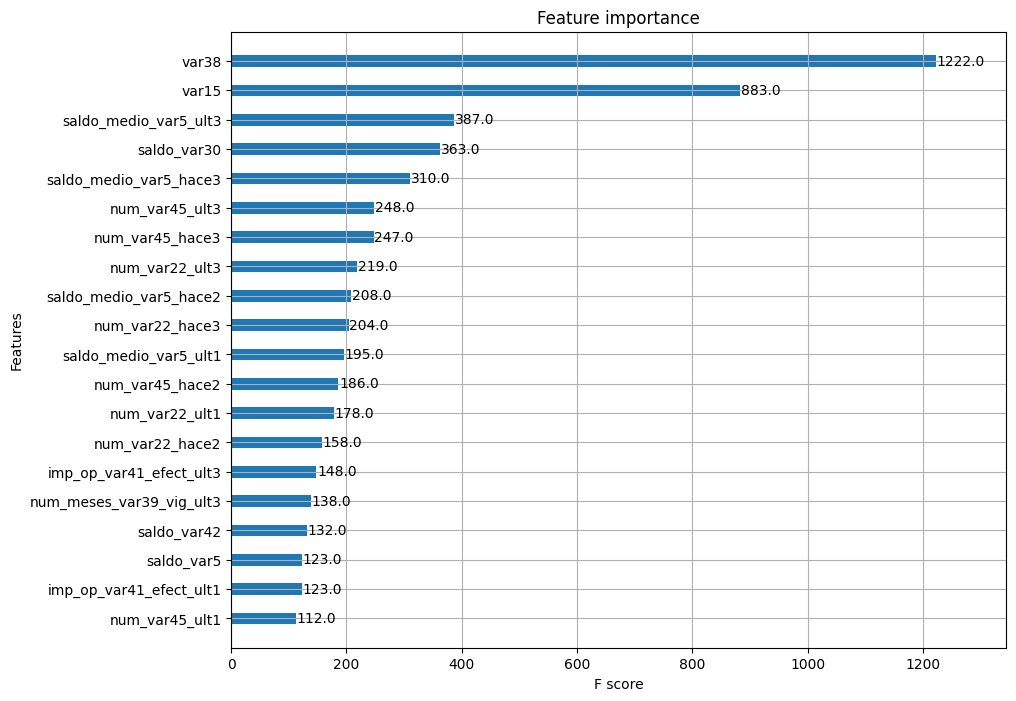

In [29]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

###### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [36]:
!pip install -U lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [41]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=100)

evals = [(X_test, y_test)]

lgbm_clf.fit(X_train, y_train)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))


[LightGBM] [Info] Number of positive: 1818, number of negative: 45454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.350158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 47272, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038458 -> initscore=-3.218964
[LightGBM] [Info] Start training from score -3.218964
ROC AUC: 0.8245


In [43]:
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200)
params ={'num_leaves': [32, 46],
        'max_depth': [128, 160],
        'min_child_samples': [60, 100],
        'subsample': [0.8, 1]}

gridcv =GridSearchCV(lgbm_clf, param_grid=params, cv=2)
gridcv.fit(X_train, y_train)
print('Gridsearchcv 최적 파라미터:', gridcv.best_params_)

lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 909, number of negative: 22727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11403
[LightGBM] [Info] Number of data points in the train set: 23636, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038458 -> initscore=-3.218964
[LightGBM] [Info] Start training from score -3.218964
[LightGBM] [Info] Number of positive: 909, number of negative: 22727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11445
[LightGBM] [Info] Number of data points in the train set: 23636, number of used features: 189
[LightGBM] [Info] 

In [45]:
# ROC-AUC 측정 결과 도출
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100, max_depth=128, evals = [(X_test, y_test)])

lgbm_clf.fit(X_train, y_train)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] 117310.979016 is set=, 117310.979016= will be ignored. Current value: 117310.979016=
[LightGBM] [Warning] 117310.979016 is set=, 117310.979016= will be ignored. Current value: 117310.979016=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] \ is set=, \= will be ignored. Current value: \=
[LightGBM] [Warning] \ is set=, \= will be ignored. Current value: \=
[LightGBM] [Warnin

###### **04-09** 분류 실습 - 캐글 신용카드 사기 검출

- **언더 샘플링**: 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소
- **오버 샘플링**: 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식
    - 과적합 가능성 신경쓰기

In [46]:
!pip install imbalanced-learn

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0


In [48]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [53]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)

    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    # NaN 값을 해당 열의 중간값으로 대체합니다.
    y_target.fillna(y_target.median(), inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [54]:
print('학습 데이터 레이블값 비율')
print(y_train.value_counts()/y_train.shape[0] * 10)
print('테스트 데이터 레이블값 비율')
print(y_test.value_counts()/y_test.shape[0] * 10)

학습 데이터 레이블값 비율
Class
0.0    9.97642
1.0    0.02358
Name: count, dtype: float64
테스트 데이터 레이블값 비율
Class
0.0    9.976693
1.0    0.023307
Name: count, dtype: float64


In [55]:
# get_clf_eval() 함수 호출
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [59]:
# 로지스틱 회귀 사용 - 예측 성능 변화 비교
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()

# NaN 값을 해당 열의 중간값으로 대체합니다.
X_train.fillna(X_train.median(), inplace=True)

lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[26101    10]
 [   32    29]]
정확도: 0.9984, 정밀도: 0.7436, 재현율: 0.4754,    F1: 0.5800, AUC:0.8978


In [60]:
# 학습/예측/평가를 위한 추가 함수 정의
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model. predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [61]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, njobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Number of positive: 144, number of negative: 60924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 61068, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

앞의 로지스틱 회귀보다는 높은 수치.

###### 데이터 분포도 변환 후 모델 학습/예측/평가

<Axes: xlabel='Amount', ylabel='Density'>

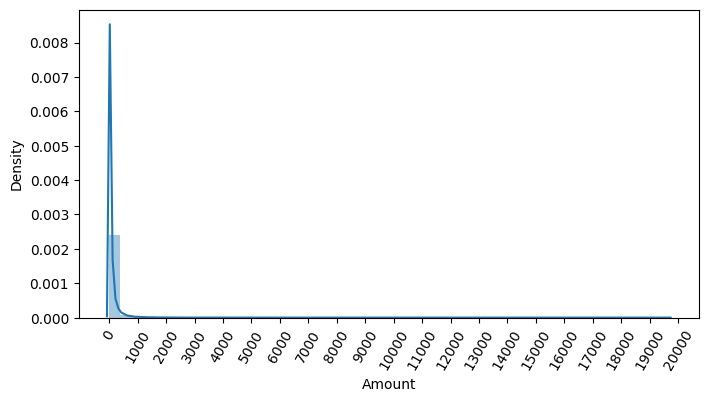

In [62]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [63]:
# 로지스틱 회귀의 예측 성능 측정
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount Scaled', amount_n)

    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [66]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
X_train.fillna(X_train.median(), inplace=True)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측 성능')
lgbm_clf =LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[26104     7]
 [   30    31]]
정확도: 0.9986, 정밀도: 0.8158, 재현율: 0.5082,    F1: 0.6263, AUC:0.9678
LightGBM 예측 성능
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 60924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 61068, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002358 -> initscore=-6.047569
[LightGBM] [Info] Start training from score -6.047569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [68]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [70]:
X_train, X_test, y_train, y_test =get_train_test_dataset(card_df)
print('로지스틱 회귀 예측 성능')
X_train.fillna(X_train.median(), inplace=True)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[26104     7]
 [   30    31]]
정확도: 0.9986, 정밀도: 0.8158, 재현율: 0.5082,    F1: 0.6263, AUC:0.9650
LightGBM 예측 성능
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 144, number of negative: 60924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 61068, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002358 -> initscore=-6.047569
[LightGBM] [Info] Start training from score -6.047569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

###### 이상치 데이터 제거 후 모델 학습/예측/평가
- IQR(Inter Quantile Range) 방식 적용

<Axes: >

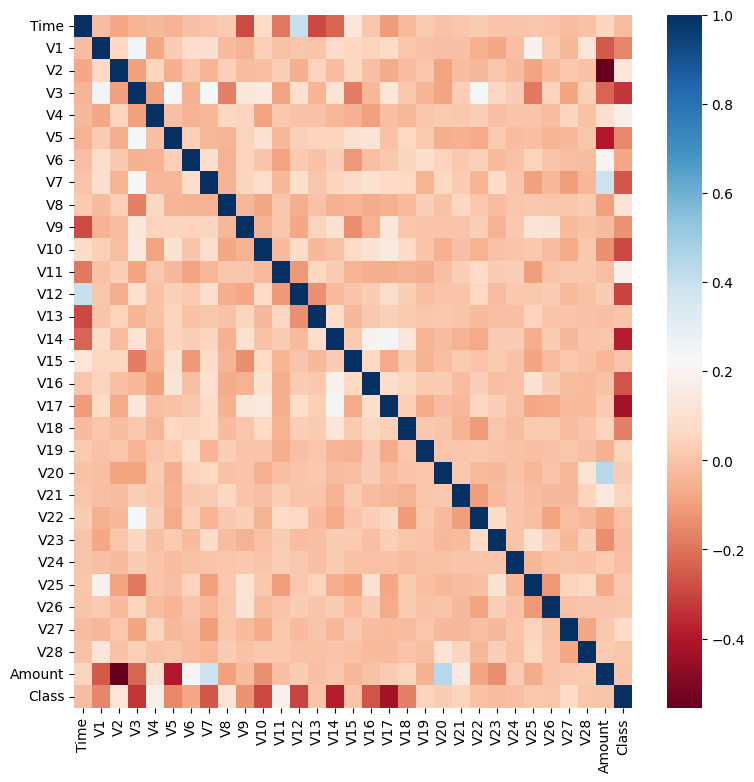

In [72]:
import seaborn as sns
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [75]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight

    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

In [76]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296], dtype='int64')


In [79]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
X_train.fillna(X_train.median(), inplace=True)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측 성능' )
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[26104     7]
 [   31    30]]
정확도: 0.9985, 정밀도: 0.8108, 재현율: 0.4918,    F1: 0.6122, AUC:0.9551
LightGBM 예측 성능
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 143, number of negative: 60924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 61067, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002342 -> initscore=-6.054538
[LightGBM] [Info] Start training from score -6.054538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

###### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [90]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:' , X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (61067, 29) (61067,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (121848, 29) (121848,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0.0    60924
1.0    60924
Name: count, dtype: int64


In [91]:
lr_clf = LogisticRegression()

get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[25614   497]
 [    6    55]]
정확도: 0.9808, 정밀도: 0.0996, 재현율: 0.9016,    F1: 0.1794, AUC:0.9773


In [92]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# precision_recall_curve_plot() 함수 호출
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: threshold_boundary], linestyle='-', label='precision')
    plt.plot(thresholds, recalls[0: threshold_boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

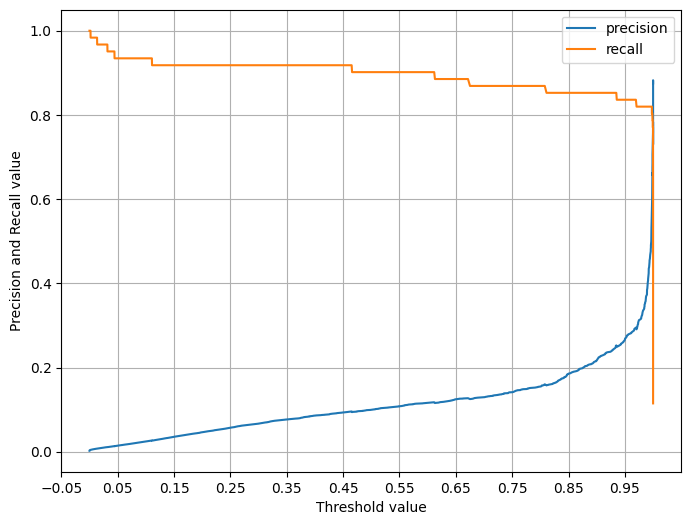

In [93]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])